<a href="https://colab.research.google.com/github/MatteoAldovardi92/Datascience-and-Machine-Learning-Sandbox/blob/main/GradientBoosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np


class RegressionTree:
    def __init__(self, min_samples_split=2, max_depth=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.tree = None

    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.var(y) * len(y)

    def _split(self, X_column, threshold):
        left_idx = np.where(X_column <= threshold)
        right_idx = np.where(X_column > threshold)
        return left_idx[0], right_idx[0]

    def _best_split(self, X, y):
        best_mse = float('inf')
        best_idx, best_thr = None, None

        for feature_idx in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_idx, right_idx = self._split(X[:, feature_idx], threshold)
                if len(left_idx) == 0 or len(right_idx) == 0:
                    continue
                mse = self._mse(y[left_idx]) + self._mse(y[right_idx])
                if mse < best_mse:
                    best_mse = mse
                    best_idx = feature_idx
                    best_thr = threshold
        return best_idx, best_thr

    def _build_tree(self, X, y, depth):
        if (len(y) < self.min_samples_split) or (depth >= self.max_depth):
            return np.mean(y)

        feature_idx, threshold = self._best_split(X, y)
        if feature_idx is None:
            return np.mean(y)

        left_idx, right_idx = self._split(X[:, feature_idx], threshold)
        left_subtree = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right_subtree = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        return {
            'feature': feature_idx,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree
        }

    def fit(self, X, y):
        self.tree = self._build_tree(np.array(X), np.array(y), 0)

    def _predict_one(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        if x[tree['feature']] <= tree['threshold']:
            return self._predict_one(x, tree['left'])
        else:
            return self._predict_one(x, tree['right'])

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])


# The GB

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

# Generate dummy regression data
X, y = make_regression(n_samples=100, n_features=1, noise=10, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit first tree
tree1 = DecisionTreeRegressor(max_depth=3)
tree1.fit(X_train, y_train)
y_pred_1 = tree1.predict(X_train)

# Fit second tree to residuals
residuals = y_train - y_pred_1
tree2 = DecisionTreeRegressor(max_depth=3)
tree2.fit(X_train, residuals)

# Predict on test data
y_pred_test_1 = tree1.predict(X_test)
residual_pred_test = tree2.predict(X_test)
lr = 0.01
y_pred_final = y_pred_test_1 + lr * residual_pred_test



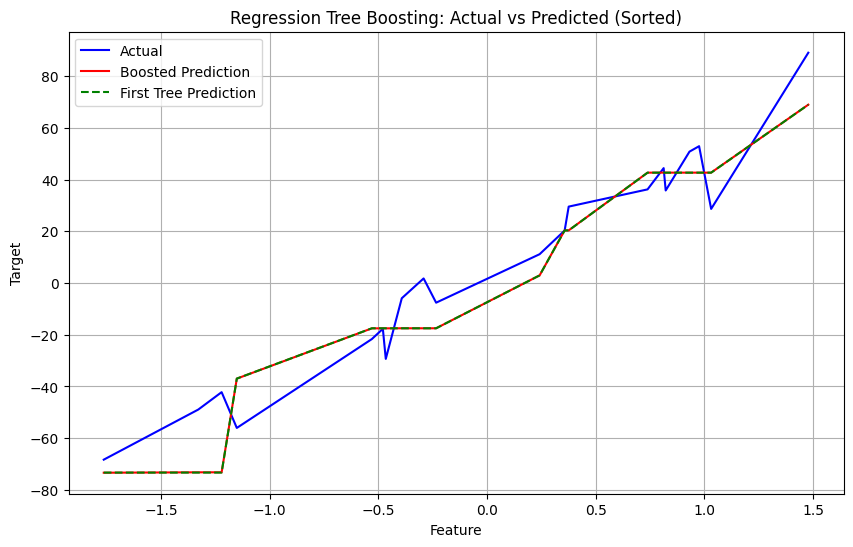

In [3]:

# Sort the test data by X values for better visualization
sorted_idx = np.argsort(X_test.flatten())
X_test_sorted = X_test[sorted_idx]
y_test_sorted = y_test[sorted_idx]
y_pred_final_sorted = y_pred_final[sorted_idx]
y_pred_test_1_sorted = y_pred_test_1[sorted_idx]

# Plot the sorted predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(X_test_sorted, y_test_sorted, 'b-', label='Actual')
plt.plot(X_test_sorted, y_pred_final_sorted, 'r-', label='Boosted Prediction')
plt.plot(X_test_sorted, y_pred_test_1_sorted, 'g--', label='First Tree Prediction')
plt.legend()
plt.title("Regression Tree Boosting: Actual vs Predicted (Sorted)")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.grid(True)
plt.show()


### More bootstrap rounds with learning rate decay

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

# Generate dummy regression data
X, y = make_regression(n_samples=100, n_features=1, noise=10, random_state=42)
M = 10000 # Rounds of Boosting

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit first tree
tree1 = DecisionTreeRegressor(max_depth=3)
tree1.fit(X_train, y_train)
y_pred = tree1.predict(X_train)
y_pred_1 = y_pred # To set aside the first model

trees = [ ]
lr = 0.04

y_pred = np.zeros_like(y_train)
for m in range(M):  # M = number of boosting rounds
    tree = RegressionTree(max_depth=3)
    tree.fit(X_train, y_train - y_pred)
    if m % 1000 == 0:
      lr = lr/10
    y_pred += lr * tree.predict(X_train)
    trees.append(tree)





In [8]:
y_pred = tree1.predict(X_test)
for tree in trees:  # M = number of boosting rounds
    y_pred += lr * tree.predict(X_test)



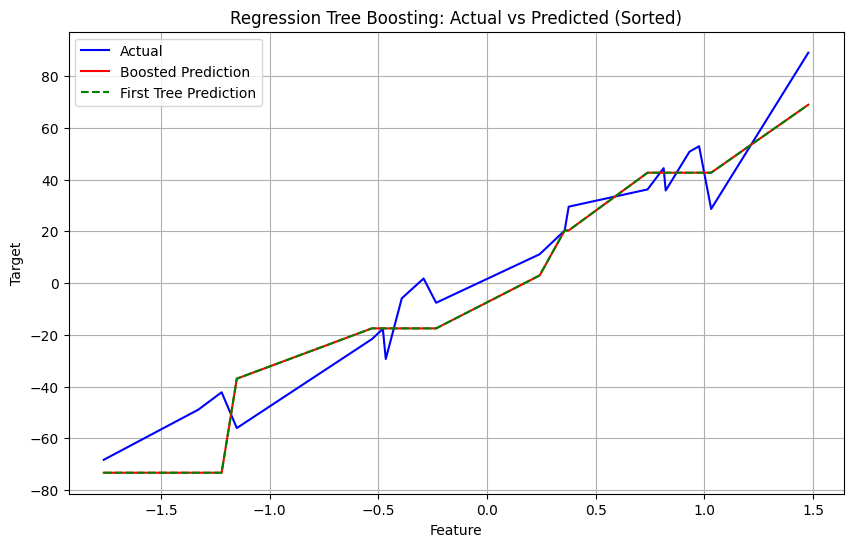

In [9]:
# Sort the test data by X values for better visualization
sorted_idx = np.argsort(X_test.flatten())
X_test_sorted = X_test[sorted_idx]
y_test_sorted = y_test[sorted_idx]
y_pred_final_sorted = y_pred[sorted_idx]
y_pred_test_1_sorted = y_pred_test_1[sorted_idx]

# Plot the sorted predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(X_test_sorted, y_test_sorted, 'b-', label='Actual')
plt.plot(X_test_sorted, y_pred_final_sorted, 'r-', label='Boosted Prediction')
plt.plot(X_test_sorted, y_pred_test_1_sorted, 'g--', label='First Tree Prediction')
plt.legend()
plt.title("Regression Tree Boosting: Actual vs Predicted (Sorted)")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.grid(True)
plt.show()


### Training loop implementing overfitting, early stopping, learning decay.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Dummy data
X, y = make_regression(n_samples=100, n_features=1, noise=10, random_state=42)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split train into train and validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# Parameters
M = 100000
lr = 0.04
trees = []
y_pred_tr = np.zeros_like(y_tr)
y_pred_val = np.zeros_like(y_val)

# Early stopping
best_mse = float("inf")
patience = 100
no_improve = 0

from sklearn.tree import DecisionTreeRegressor  # or your own RegressionTree

for m in range(M):
    tree = RegressionTree(max_depth=3)
    # Fit on residuals of training set
    tree.fit(X_tr, y_tr - y_pred_tr)
    pred_tr = tree.predict(X_tr)
    pred_val = tree.predict(X_val)

    # Update predictions
    if m % 1000 == 0:
      lr = lr/2
    y_pred_tr += lr * pred_tr
    y_pred_val += lr * pred_val

    # Check validation performance
    mse = mean_squared_error(y_val, y_pred_val)
    if mse < best_mse:
        best_mse = mse
        no_improve = 0
    else:
        no_improve += 1
        if no_improve > patience:
            print(f"Early stopping at round {m}")
            break

    # Optional learning rate decay
    if m % 1000 == 0 and m > 0:
        lr = max(lr / 10, 1e-5)

    trees.append(tree)

# Final test prediction
y_pred_test1 = trees[0].predict(X_test)
y_pred_test = np.zeros_like(y_test)
for tree in trees:
    y_pred_test += lr * tree.predict(X_test)

print("Test MSE:", mean_squared_error(y_test, y_pred_test))


Early stopping at round 219
Test MSE: 156.22137733889986


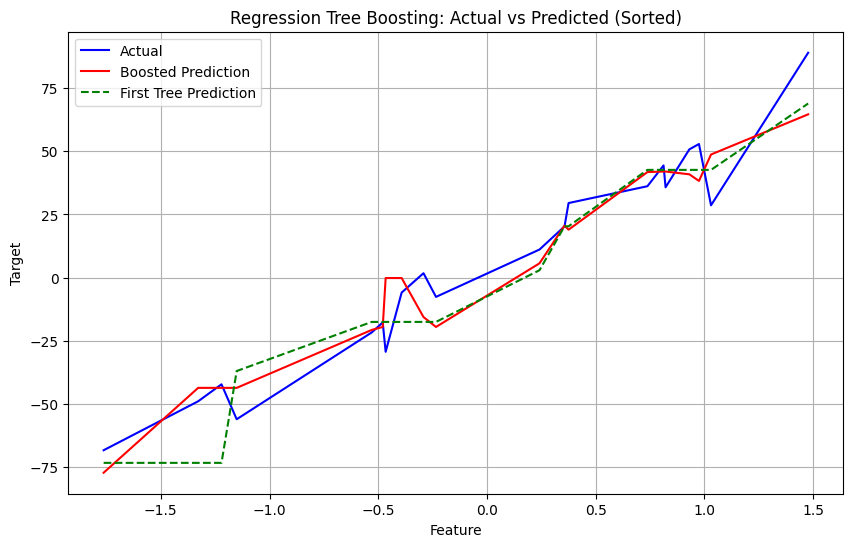

In [19]:
# Sort the test data by X values for better visualization
sorted_idx = np.argsort(X_test.flatten())
X_test_sorted = X_test[sorted_idx]
y_test_sorted = y_test[sorted_idx]
y_pred_final_sorted = y_pred_test[sorted_idx]
y_pred_test_1_sorted = y_pred_test_1[sorted_idx]

# Plot the sorted predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(X_test_sorted, y_test_sorted, 'b-', label='Actual')
plt.plot(X_test_sorted, y_pred_final_sorted, 'r-', label='Boosted Prediction')
plt.plot(X_test_sorted, y_pred_test_1_sorted, 'g--', label='First Tree Prediction')
plt.legend()
plt.title("Regression Tree Boosting: Actual vs Predicted (Sorted)")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.grid(True)
plt.show()
